In [398]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pandas as pd
import numpy as np
import pkg_resources
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import model_bias_analysis

# autoreload makes it easier to interactively work on code in the model_bias_analysis module.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [399]:
# Shared functions

In [400]:
def convert_to_boolean_labels(labels):
    return np.where(labels >= 0.5, True, False)

In [401]:
def scatterplot(results, model_1, model_2, y_label, ylim=(0.8, 1.0)):
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)
    #bar_width = 0.35
    point_size=15
    for i, (_index, row) in enumerate(results.iterrows()):
        # For each subgroup, we plot a 1D scatterplot. The x-value is the position
        # of the item in the dataframe. To change the ordering of the subgroups,
        # sort the dataframe before passing to this function.
        x = [i] * 2
        y = [row[model_1], row[model_2]]
        ax.scatter(x, y, s=0)
        #if (abs(y[1] - y[0]) > 0.003):
        plt.arrow(x[0],y[0], 0, y[1] - y[0], length_includes_head=True, shape='full', head_starts_at_zero=False, head_length=0.005, head_width=0.3, color='black')
    ax.set_xticklabels(results['subgroup'], rotation=90)
    ax.set_xticks(range(len(results)))
    ax.set_ylim(ylim)
    ax.set_title(y_label)
    fig.tight_layout()
    #fig.savefig('/tmp/%s_%s.eps' % (file_name, values_col), format='eps')

In [402]:
# MADLIBS set up

In [403]:
model_families = [
    ['Rock:TOXICITY'],#, 'wiki_cnn_v3_101', 'wiki_cnn_v3_102'],
    ['RockV5_1:TOXICITY'],# 'wiki_debias_cnn_v3_101', 'wiki_debias_cnn_v3_102'],
    ['RockV6_1:TOXICITY'],
]

In [404]:
madlibs = pd.read_csv('eval_datasets/bias_madlibs_77k_scored_prod_models.csv')

In [405]:
# Add columns for each subgroup.
f = open('bias_madlibs_data/adjectives_people.txt', 'r')
terms = [line.strip() for line in f]
model_bias_analysis.add_subgroup_columns_from_text(madlibs, 'Text', terms)

In [406]:
madlibs['label_bool'] = madlibs.apply(lambda row: row.Label == 'BAD', axis=1)

In [407]:
madlibs_results = model_bias_analysis.per_subgroup_aucs(madlibs, terms, model_families, 'label_bool')

In [408]:
madlibs_results['TOXICITY_V1_pinned_auc'] = madlibs_results.apply(lambda row: row['Rock:TOXICITY_aucs'][0], axis=1)
madlibs_results['TOXICITY_V5_pinned_auc'] = madlibs_results.apply(lambda row: row['RockV5_1:TOXICITY_aucs'][0], axis=1)
madlibs_results['TOXICITY_V6_pinned_auc'] = madlibs_results.apply(lambda row: row['RockV6_1:TOXICITY_aucs'][0], axis=1)

madlibs_results['TOXICITY_V1_weighted_pinned_auc'] = madlibs_results.apply(lambda row: row['Rock:TOXICITY_normalized_pinned_aucs'][0], axis=1)
madlibs_results['TOXICITY_V5_weighted_pinned_auc'] = madlibs_results.apply(lambda row: row['RockV5_1:TOXICITY_normalized_pinned_aucs'][0], axis=1)
madlibs_results['TOXICITY_V6_weighted_pinned_auc'] = madlibs_results.apply(lambda row: row['RockV6_1:TOXICITY_normalized_pinned_aucs'][0], axis=1)

madlibs_results['TOXICITY_V1_negative_aeg'] = madlibs_results.apply(lambda row: row['Rock:TOXICITY_within_negative_label_mwus'][0], axis=1)
madlibs_results['TOXICITY_V5_negative_aeg'] = madlibs_results.apply(lambda row: row['RockV5_1:TOXICITY_within_negative_label_mwus'][0], axis=1)
madlibs_results['TOXICITY_V6_negative_aeg'] = madlibs_results.apply(lambda row: row['RockV6_1:TOXICITY_within_negative_label_mwus'][0], axis=1)

madlibs_results['TOXICITY_V1_positive_aeg'] = madlibs_results.apply(lambda row: row['Rock:TOXICITY_within_positive_label_mwus'][0], axis=1)
madlibs_results['TOXICITY_V5_positive_aeg'] = madlibs_results.apply(lambda row: row['RockV5_1:TOXICITY_within_positive_label_mwus'][0], axis=1)
madlibs_results['TOXICITY_V6_positive_aeg'] = madlibs_results.apply(lambda row: row['RockV6_1:TOXICITY_within_positive_label_mwus'][0], axis=1)

In [409]:
# Real Data set up 

In [410]:
human_labels = [
 'toxicity',
 'severe_toxicity',
 'obscene',
 'sexual_explicit',
 'identity_attack',
 'insult',
 'threat',
 'male',
 'female',
 'transgender',
 'other_gender',
 'heterosexual',
 'homosexual_gay_or_lesbian',
 'bisexual',
 'other_sexual_orientation',
 'christian',
 'jewish',
 'muslim',
 'hindu',
 'buddhist',
 'atheist',
 'other_religion',
 'black',
 'white',
 'asian',
 'latino',
 'other_race_or_ethnicity',
 'physical_disability',
 'intellectual_or_learning_disability',
 'psychiatric_or_mental_illness',
 'other_disability']

identities = [
 'male',
 'female',
 'transgender',
 'heterosexual',
 'homosexual_gay_or_lesbian',
 'bisexual',
 'christian',
 'jewish',
 'muslim',
 'hindu',
 'buddhist',
 'atheist',
 'other_religion',
 'black',
 'white',
 'asian',
 'latino',
 'other_race_or_ethnicity',
 'physical_disability',
 'intellectual_or_learning_disability',
 'psychiatric_or_mental_illness']

In [411]:
real_data = pd.read_csv('eval_datasets/identity_labeled_scored.csv')

In [412]:
real_data_model_families = [
    ['rock_toxicity'],#, 'wiki_cnn_v3_101', 'wiki_cnn_v3_102'],
    ['rock_v6_1_toxicity'],# 'wiki_debias_cnn_v3_101', 'wiki_debias_cnn_v3_102'],
]

In [413]:
for human_label in human_labels:
    real_data[human_label] = convert_to_boolean_labels(real_data[human_label])

In [414]:
real_data_results = model_bias_analysis.per_subgroup_aucs(real_data, identities, real_data_model_families, 'toxicity')

In [415]:
real_data_results['TOXICITY_V1_pinned_auc'] = real_data_results.apply(lambda row: row['rock_toxicity_aucs'][0], axis=1)
real_data_results['TOXICITY_V6_pinned_auc'] = real_data_results.apply(lambda row: row['rock_v6_1_toxicity_aucs'][0], axis=1)

real_data_results['TOXICITY_V1_weighted_pinned_auc'] = real_data_results.apply(lambda row: row['rock_toxicity_normalized_pinned_aucs'][0], axis=1)
real_data_results['TOXICITY_V6_weighted_pinned_auc'] = real_data_results.apply(lambda row: row['rock_v6_1_toxicity_normalized_pinned_aucs'][0], axis=1)

real_data_results['TOXICITY_V1_negative_aeg'] = real_data_results.apply(lambda row: row['rock_toxicity_within_negative_label_mwus'][0], axis=1)
real_data_results['TOXICITY_V6_negative_aeg'] = real_data_results.apply(lambda row: row['rock_v6_1_toxicity_within_negative_label_mwus'][0], axis=1)

real_data_results['TOXICITY_V1_positive_aeg'] = real_data_results.apply(lambda row: row['rock_toxicity_within_positive_label_mwus'][0], axis=1)
real_data_results['TOXICITY_V6_positive_aeg'] = real_data_results.apply(lambda row: row['rock_v6_1_toxicity_within_positive_label_mwus'][0], axis=1)


In [416]:
# RESULTS

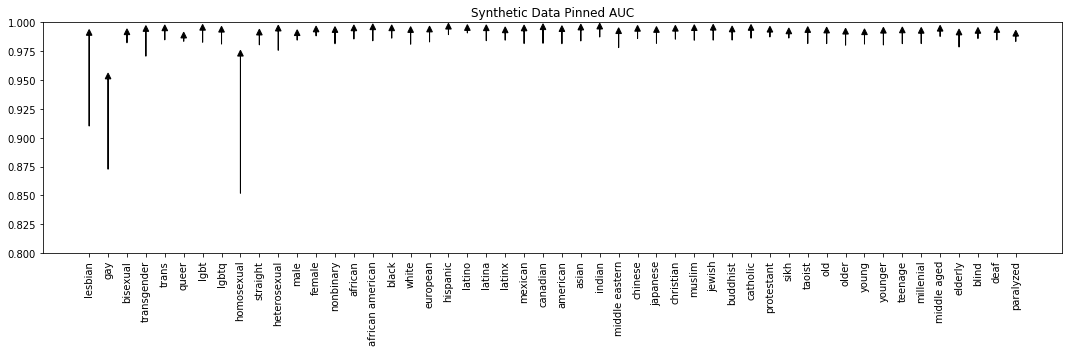

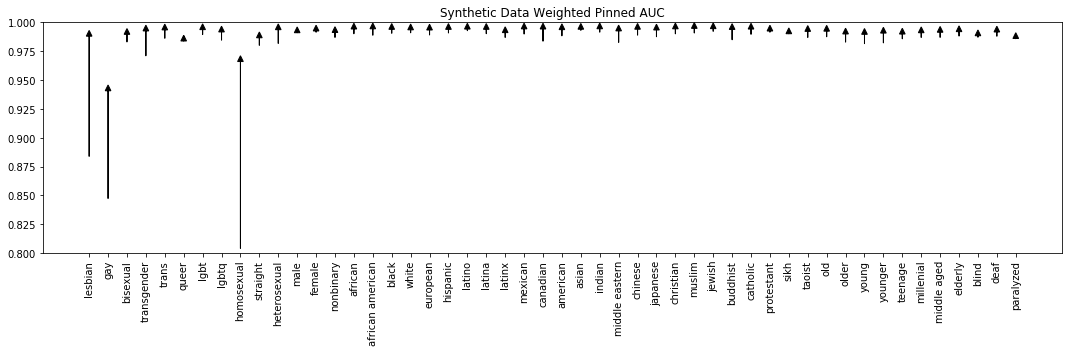

In [417]:
scatterplot(madlibs_results, 'TOXICITY_V1_pinned_auc', 'TOXICITY_V6_pinned_auc', 'Synthetic Data Pinned AUC')
scatterplot(madlibs_results, 'TOXICITY_V1_weighted_pinned_auc', 'TOXICITY_V6_weighted_pinned_auc', 'Synthetic Data Weighted Pinned AUC')

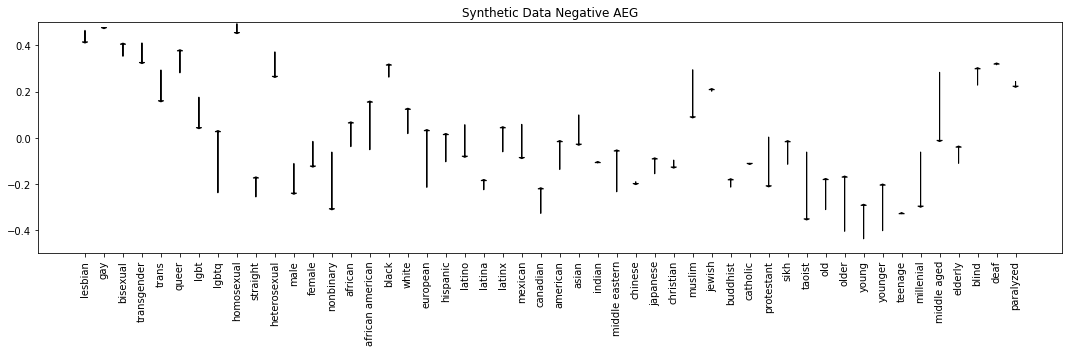

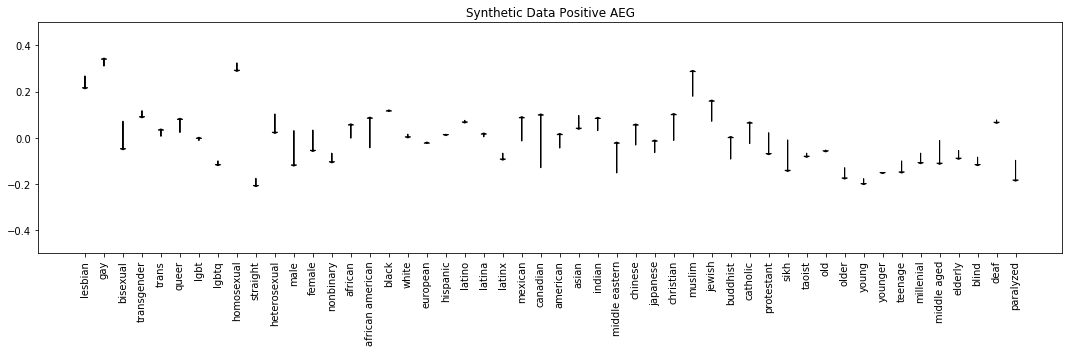

In [418]:
scatterplot(madlibs_results, 'TOXICITY_V1_negative_aeg', 'TOXICITY_V6_negative_aeg', 'Synthetic Data Negative AEG', ylim=(-0.5,0.5))
scatterplot(madlibs_results, 'TOXICITY_V1_positive_aeg', 'TOXICITY_V6_positive_aeg', 'Synthetic Data Positive AEG', ylim=(-0.5,0.5))

In [419]:
# REAL DATA

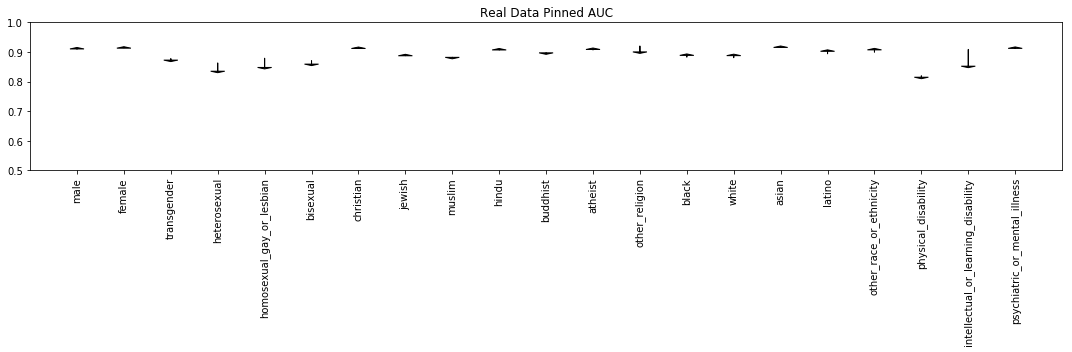

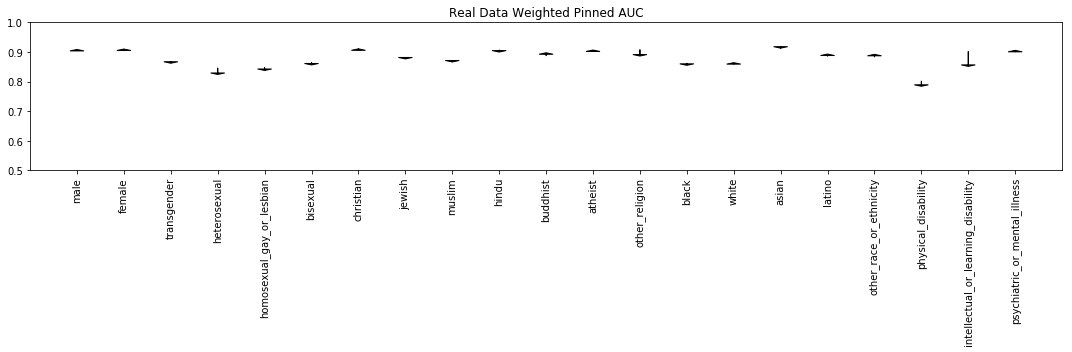

In [420]:
scatterplot(real_data_results, 'TOXICITY_V1_pinned_auc', 'TOXICITY_V6_pinned_auc', 'Real Data Pinned AUC', ylim=(0.5,1.0))
scatterplot(real_data_results, 'TOXICITY_V1_weighted_pinned_auc', 'TOXICITY_V6_weighted_pinned_auc', 'Real Data Weighted Pinned AUC', ylim=(0.5,1.0))

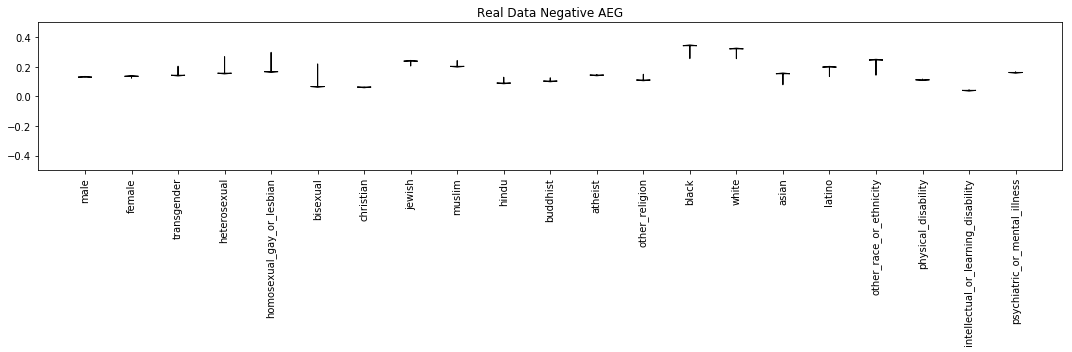

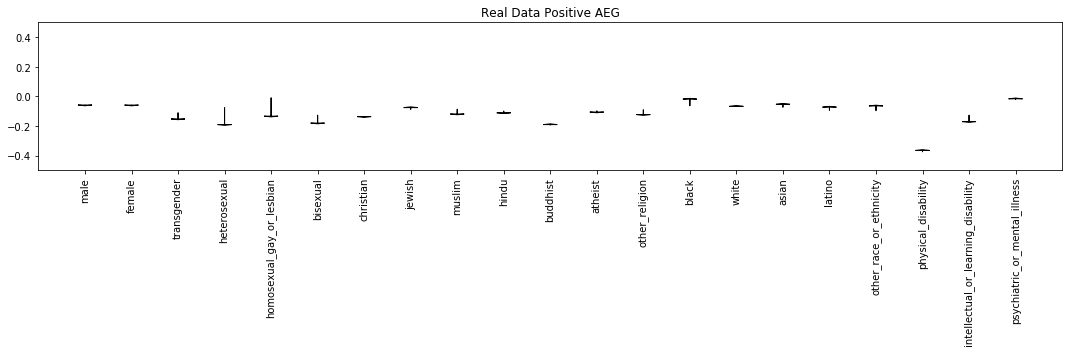

In [421]:
scatterplot(real_data_results, 'TOXICITY_V1_negative_aeg', 'TOXICITY_V6_negative_aeg', 'Real Data Negative AEG', ylim=(-0.5,0.5))
scatterplot(real_data_results, 'TOXICITY_V1_positive_aeg', 'TOXICITY_V6_positive_aeg', 'Real Data Positive AEG', ylim=(-0.5,0.5))

In [422]:
out = madlibs_results[['subgroup', 'TOXICITY_V1_pinned_auc', 'TOXICITY_V6_pinned_auc', 'TOXICITY_V1_weighted_pinned_auc', 'TOXICITY_V6_weighted_pinned_auc', 'TOXICITY_V1_negative_aeg', 'TOXICITY_V6_negative_aeg', 'TOXICITY_V1_positive_aeg', 'TOXICITY_V6_positive_aeg']]
out.to_csv('eval_datasets/bias_madlibs_77k_scored_prod_models_metrics.csv')

In [423]:
out_real = real_data_results[['subgroup', 'TOXICITY_V1_pinned_auc', 'TOXICITY_V6_pinned_auc', 'TOXICITY_V1_weighted_pinned_auc', 'TOXICITY_V6_weighted_pinned_auc', 'TOXICITY_V1_negative_aeg', 'TOXICITY_V6_negative_aeg', 'TOXICITY_V1_positive_aeg', 'TOXICITY_V6_positive_aeg']]
out_real.to_csv('eval_datasets/identity_labeled_metrics.csv')

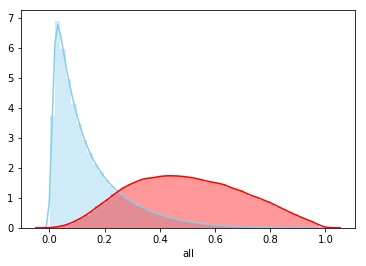

In [424]:
toxic_scores = real_data.query('toxicity == True')['rock_toxicity']
non_toxic_scores = real_data.query('toxicity == False')['rock_toxicity']
sns.distplot( non_toxic_scores , color="skyblue", axlabel='all')
sns.distplot( toxic_scores , color="red", axlabel='all')
plt.figure()

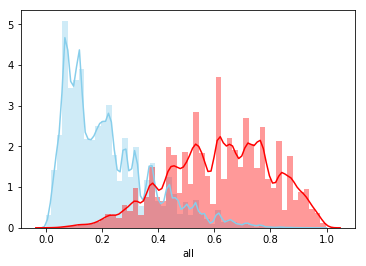

In [425]:
toxic_scores = real_data.query('toxicity == True')['rock_v6_1_toxicity']
non_toxic_scores = real_data.query('toxicity == False')['rock_v6_1_toxicity']
sns.distplot( non_toxic_scores , color="skyblue", axlabel='all')
sns.distplot( toxic_scores , color="red", axlabel='all')
plt.figure()

In [426]:
def plot_histogram(data, identity, model, label_col='toxicity'):
    toxic_scores = data.query(identity + ' == True & ' + label_col + ' == True')[model]
    non_toxic_scores = data.query(identity + ' == True & '+ label_col + ' == False')[model]
    sns.distplot( non_toxic_scores , color="skyblue", axlabel=identity)
    sns.distplot( toxic_scores , color="red", axlabel=identity)
    plt.figure()

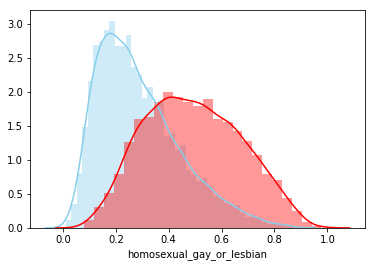

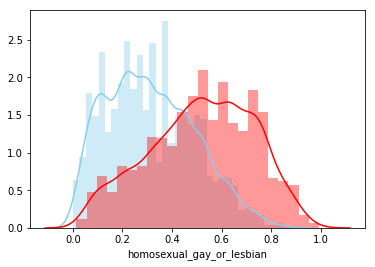

In [427]:
plot_histogram(real_data, 'homosexual_gay_or_lesbian', 'rock_toxicity')
plot_histogram(real_data, 'homosexual_gay_or_lesbian', 'rock_v6_1_toxicity')

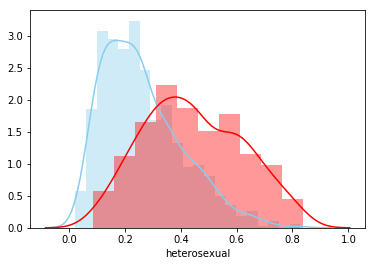

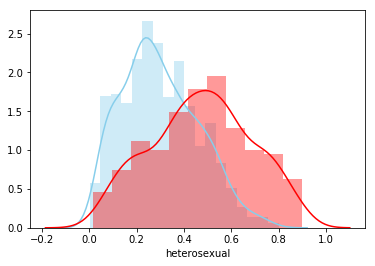

In [428]:
plot_histogram(real_data, 'heterosexual', 'rock_toxicity')
plot_histogram(real_data, 'heterosexual', 'rock_v6_1_toxicity')


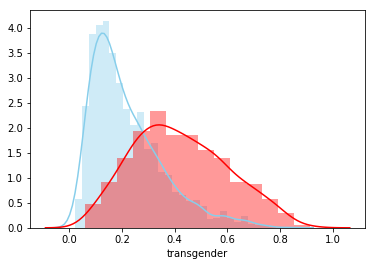

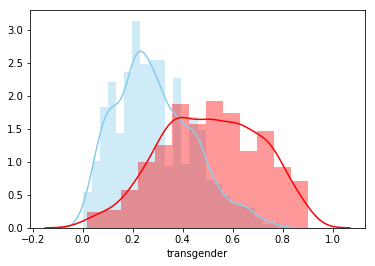

In [429]:
plot_histogram(real_data, 'transgender', 'rock_toxicity')
plot_histogram(real_data, 'transgender', 'rock_v6_1_toxicity')

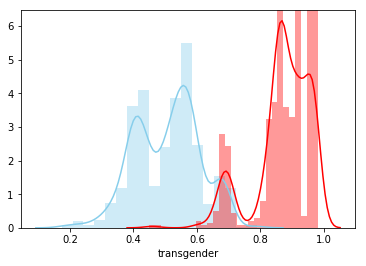

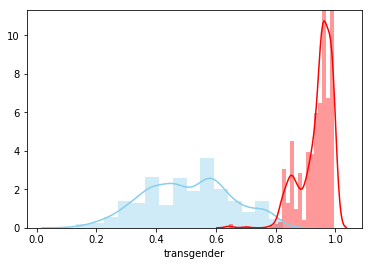

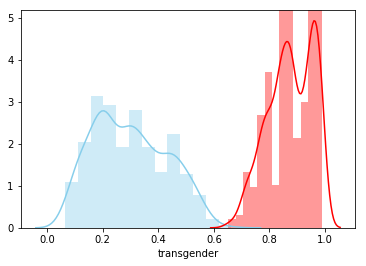

In [430]:
plot_histogram(madlibs, 'transgender', 'Rock:TOXICITY', label_col='label_bool')
plot_histogram(madlibs, 'transgender', 'RockV5_1:TOXICITY', label_col='label_bool')
plot_histogram(madlibs, 'transgender', 'RockV6_1:TOXICITY', label_col='label_bool')

In [431]:
real_data['diff'] = real_data['rock_v6_1_toxicity'] - real_data['rock_toxicity']

In [432]:
look = real_data[real_data['homosexual_gay_or_lesbian'] & (real_data.comment_text.str.len() < 100)].sort_values('diff', ascending=False)[['comment_text', 'rock_v6_1_toxicity', 'rock_toxicity', 'toxicity']]

In [433]:
pd.options.display.max_colwidth=200

In [434]:
look[look.toxicity]

,comment_text,rock_v6_1_toxicity,rock_toxicity,toxicity
1298580,Lesbians don't deserve rights anywhere. Why make it an issue in Anchorage?,0.765007,0.291104,True
1532113,"So if they refuse to dance for a black official or a gay official, you are just as approving?",0.869549,0.577486,True
1800288,Should they not pull the support of gay parades that attack all things righteous in our society?,0.716199,0.439577,True
1405028,"Mormons cannot possibly be gay. We just can't have this, and that's the end of that. /s",0.774545,0.506005,True
1415950,Please source your material that says ID believes gays are inferior people . You can't.,0.731208,0.467165,True
996748,"John A McDonald was gay,There we will never hear another word from the teachers about him",0.735537,0.476953,True
814924,"Why not send them to canada ???? \nAnd if there are any gays, then even better .................",0.762105,0.504811,True
525072,I agree. Gay men shouldn't be around children.,0.791143,0.547279,True
216790,"Your ideal minimizes gays and women, IMO. I won't be inviting you to dinner.",0.776501,0.536357,True
1799911,What was God thinking when s(he) created a homosexual animal kingdom?,0.867918,0.629446,True
